In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
image_light = cv2.imread("data/light.jpg")
image_dark = cv2.imread("data/dark.jpg")

Text(0.5, 1.0, 'Cropped Image')

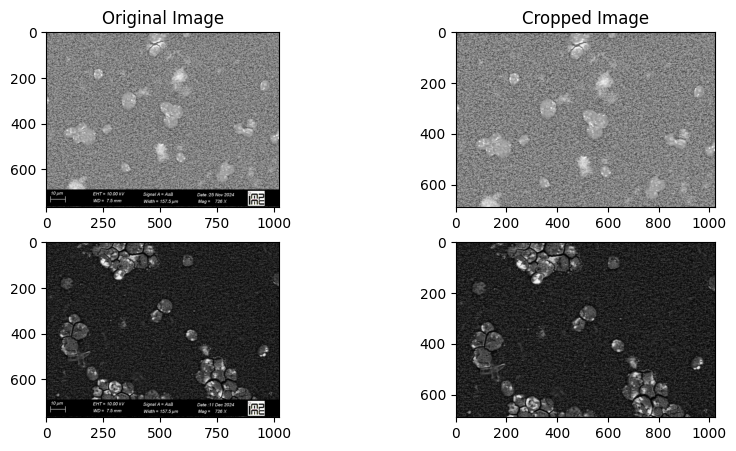

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0,0].imshow(image_light)
ax[1,0].imshow(image_dark)
ax[0,0].set_title("Original Image")

image_light = image_light[:690, :, :]
image_dark = image_dark[:690, :, :]

ax[0,1].imshow(image_light)
ax[1,1].imshow(image_dark)
ax[0,1].set_title("Cropped Image")

In [ ]:
def gamma_correct_target_d(image, target):
    """
    Perform gamma correction on the image to match the target meean intensity
    Uses dichotomy to find the gamma value
    """
    image_float = image.astype(np.float32)
    init_mean = np.mean(image)

    # Determine search direction based on target vs. initial mean
    if init_mean == target:
        return image, 1.0

    # Define lower and upper bounds for gamma
    if init_mean < target:
        # Need to decrease gamma (brighten image)
        gamma_min = 0.1
        gamma_max = 1.0
    else:
        # Need to increase gamma (darken image)
        gamma_min = 1.0
        gamma_max = 5.0

    # Dichotomy search
    max_iterations = 20
    for _ in range(max_iterations):
        gamma = (gamma_min + gamma_max) / 2

        # Apply gamma correction
        corr_image = image_float / 255.0
        corr_image = np.clip(corr_image ** gamma, 0, 1)
        corr_image = (corr_image * 255).astype(np.uint8)

        current_mean = np.mean(corr_image)

        # Check if we're close enough to target
        if abs(current_mean - target) < 0.5:
            break

        # Adjust search range
        if current_mean < target:
            gamma_max = gamma
        else:
            gamma_min = gamma

    return corr_image, gamma

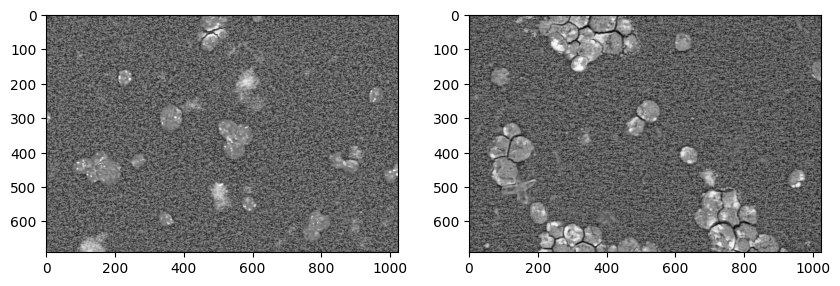

In [ ]:
corr_image_light, _ = gamma_correct_target_d(image_light, 100)
corr_image_dark, _ = gamma_correct_target_d(image_dark, 100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(corr_image_light)
ax[1].imshow(corr_image_dark)

In [ ]:
def extract_cells_infiltrations_masks(image, threshold=100, plot_verbose=False):
    if plot_verbose:
        _, ax = plt.subplots(5,2, figsize=(15, 20))
        # remove all axes
        for a in ax.flatten():
            a.axis('off')

    image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if plot_verbose:
        ax[0,0].imshow(image_grayscale, cmap='gray')
        ax[0,0].set_title("Original Image")

    light_pixels = (image_grayscale >= threshold)
    mask = image_grayscale.copy()
    mask[~light_pixels] = 0
    mask[light_pixels] = 255

    if plot_verbose:
        ax[0,1].imshow(mask)
        ax[0,1].set_title("Light Pixels")

    # apply morphological operations to remove noise
    small_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    medium_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    large_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask_filtered = mask.copy()
    mask_filtered = cv2.morphologyEx(mask_filtered, cv2.MORPH_OPEN, kernel=medium_ellipse, iterations=2)
    mask_filtered = cv2.morphologyEx(mask_filtered, cv2.MORPH_OPEN, kernel=small_ellipse, iterations=4)
    mask_filtered = cv2.morphologyEx(mask_filtered, cv2.MORPH_CLOSE, kernel=large_ellipse, iterations=1)

    if plot_verbose:
        ax[1,0].imshow(mask_filtered)
        ax[1,0].set_title("After noise filtering")

    # find contours of the mask, filter out contours that are too small
    contours, _ = cv2.findContours(mask_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_filtered_contours = mask_filtered.copy()
    mask_filtered_contours = cv2.cvtColor(mask_filtered_contours, cv2.COLOR_GRAY2BGR)
    new_mask_filtered = mask_filtered.copy()
    new_mask_filtered[:,:] = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > 800:
            cv2.drawContours(mask_filtered_contours, [c], -1, (0, 255, 0), 1)
            cv2.drawContours(new_mask_filtered, [c], -1, (255), 1)
            cv2.fillPoly(new_mask_filtered, [c], (255))
            cv2.fillPoly(mask_filtered_contours, [c], (0, 255, 0))
        else:
            cv2.drawContours(mask_filtered_contours, [c], -1, (255, 0, 0), 1)
            cv2.fillPoly(mask_filtered_contours, [c], (255, 0, 0))

    new_mask_filtered = cv2.dilate(new_mask_filtered, kernel=small_ellipse, iterations=3)

    if plot_verbose:
        ax[1,1].imshow(mask_filtered_contours)
        ax[1,1].set_title("Contours of the mask")
        ax[2,0].imshow(new_mask_filtered)
        ax[2,0].set_title("After contour area filtering")

    # find pixels that are not white but are gray
    only_gray_pixels = cv2.bitwise_and((image_grayscale > threshold).astype(np.uint8), (image_grayscale < threshold + 50).astype(np.uint8))
    only_gray_pixels = only_gray_pixels.astype(np.bool)

    if plot_verbose:
        ax[2,1].imshow(only_gray_pixels)
        ax[2,1].set_title('Gray Pixels')


    mask_gray = image_grayscale.copy()
    mask_gray[~only_gray_pixels] = 0
    mask_gray[only_gray_pixels] = 255

    # apply morphological operations to remove noise
    mask_morph_gray = mask_gray.copy()
    mask_morph_gray = cv2.morphologyEx(mask_morph_gray, cv2.MORPH_OPEN, kernel=small_ellipse, iterations=5)
    mask_morph_gray = cv2.morphologyEx(mask_morph_gray, cv2.MORPH_CLOSE, kernel=large_ellipse, iterations=5)

    if plot_verbose:
        ax[3,0].imshow(mask_morph_gray, cmap='gray')
        ax[3,0].set_title('Gray Pixels after conservative noise filtering')

    # Find contours in new_mask
    contours, _ = cv2.findContours(new_mask_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create RGB images for visualization
    validated_mask = np.zeros_like(new_mask_filtered)

    visualization = image.copy()
    visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)

    # Check each contour for overlap with mask_morph
    valid_contours = []
    invalid_contours = []

    for contour in contours:
        # Create a temporary mask for this contour
        temp_mask = np.zeros_like(new_mask_filtered)
        cv2.drawContours(temp_mask, [contour], 0, 255, -1)

        # Check if there's any overlap with mask_morph
        overlap = cv2.bitwise_and(temp_mask, mask_morph_gray)
        if np.any(overlap):
            # Valid contour (has overlap)
            valid_contours.append(contour)
            cv2.drawContours(validated_mask, [contour], 0, 255, -1)
            cv2.drawContours(visualization, [contour], 0, (0, 255, 0), 2)  # Green for valid
        else:
            # Invalid contour (no overlap)
            invalid_contours.append(contour)
            cv2.drawContours(visualization, [contour], 0, (255, 0, 0), 2)  # Red for invalid

    if plot_verbose:
        ax[4,0].imshow(validated_mask)
        ax[4,0].set_title('Final Mask')
        ax[4,1].imshow(cv2.bitwise_and(image, image, mask=validated_mask))
        ax[4,1].set_title("Masked Image")

    # Create visualization with filled contours
    overlay = np.zeros_like(visualization)
    for contour in valid_contours:
        cv2.fillPoly(overlay, [contour], (0, 255, 0))  # Green for valid
    for contour in invalid_contours:
        cv2.fillPoly(overlay, [contour], (255, 0, 0))  # Red for invalid

    # Combine original image with overlay
    final_visualization = cv2.addWeighted(visualization, 0.7, overlay, 0.3, 0)

    if plot_verbose:
        ax[3,1].imshow(final_visualization)
        ax[3,1].set_title('Filtering out white clouds')

    white_pixels = (image_grayscale >= 175)
    white_mask = image_grayscale.copy()
    white_mask[~white_pixels] = 0
    white_mask[white_pixels] = 255

    # keep only white pixels in the validated mask
    white_mask = cv2.bitwise_and(white_mask, validated_mask)

    if plot_verbose:
        plt.show()

    return validated_mask, white_mask

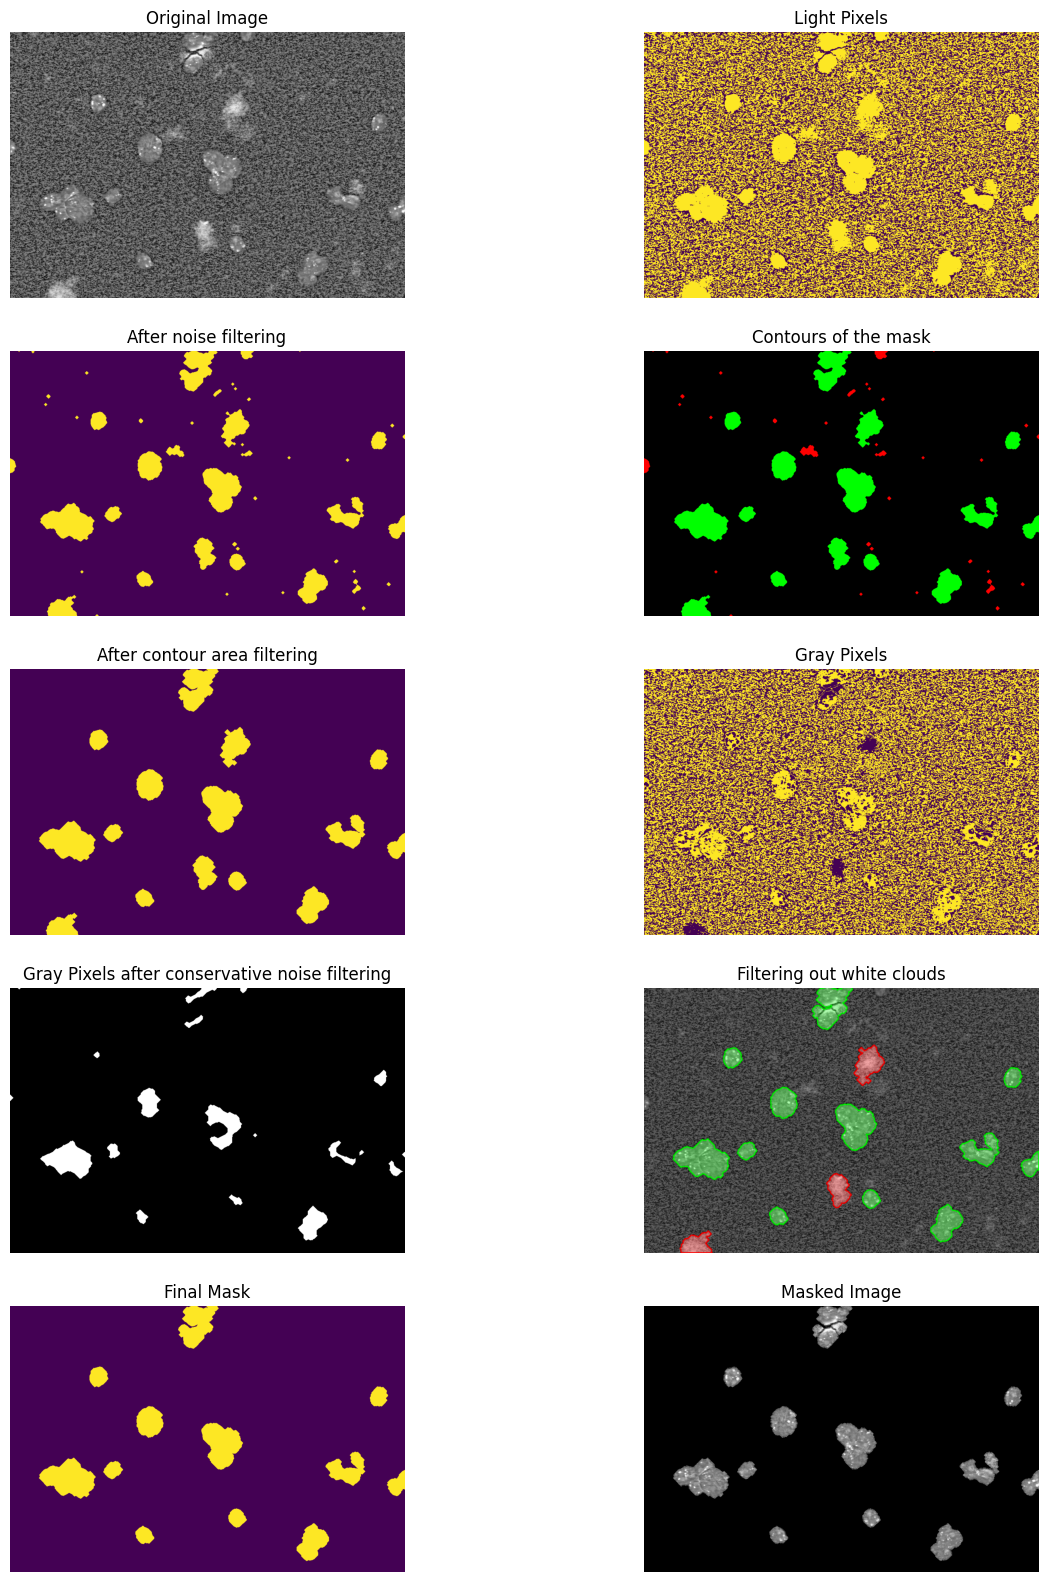

In [ ]:
_,_ = extract_cells_infiltrations_masks(corr_image_light, plot_verbose=True)

In [ ]:
def visualize_result(image, gray_mask, white_mask):
    # apply weighted gray_pixels_in_new_mask in red and white pixels mask in green
    masked_image = image.copy()
    # to rgb
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    gray_pixels = cv2.subtract(gray_mask.astype('uint8'), white_mask.astype('uint8'))
    gray_pixels_rgb = cv2.cvtColor(gray_pixels.astype('uint8'), cv2.COLOR_GRAY2RGB)*255
    white_pixels_rgb = cv2.cvtColor(white_mask.astype('uint8'), cv2.COLOR_GRAY2RGB)*255
    gray_pixels_rgb[gray_pixels == 255] = [255, 0, 0]
    white_pixels_rgb[white_mask == 255] = [0, 255, 0]

    masked_image = cv2.addWeighted(masked_image, 1, gray_pixels_rgb, 0.8, 0)
    masked_image = cv2.addWeighted(masked_image, 1, white_pixels_rgb, 0.8, 0)
    return masked_image

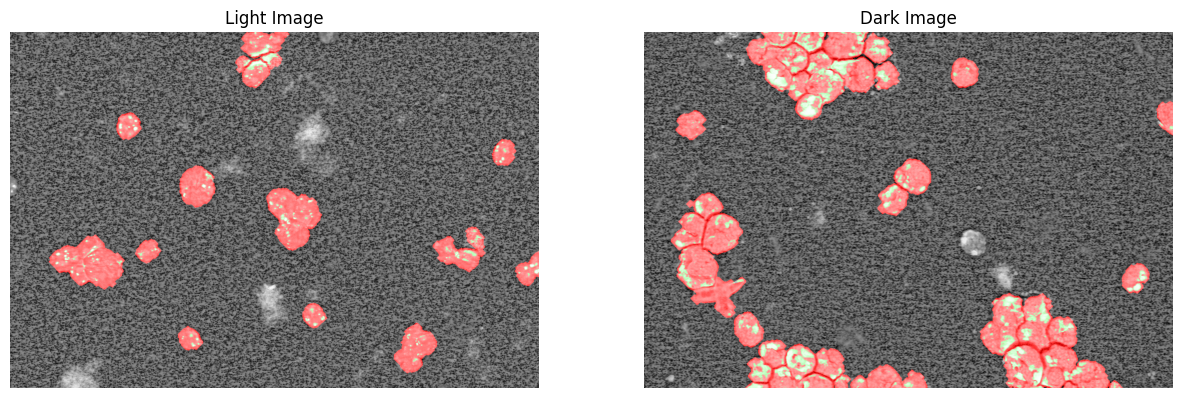

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(visualize_result(corr_image_light, *extract_cells_infiltrations_masks(corr_image_light, plot_verbose=False)))
ax[1].imshow(visualize_result(corr_image_dark, *extract_cells_infiltrations_masks(corr_image_dark, plot_verbose=False)))
ax[0].set_title("Light Image")
ax[1].set_title("Dark Image")
ax[0].axis('off')
ax[1].axis('off')
plt.show()